This is Kelly Wiseman's Ipython notebook from the completed Restaurant Revenue Prediction Kaggle competition. Check out *[Kaggle's website](https://www.kaggle.com/c/restaurant-revenue-prediction/overview)* for more competition details and data files.

# Restaurant Revenue Prediction 
With over 1,200 quick service restaurants across the globe, TFI is the company behind some of the world's most well-known brands: Burger King, Sbarro, Popeyes, Usta Donerci, and Arby’s. They employ over 20,000 people in Europe and Asia and make significant daily investments in developing new restaurant sites.

Right now, deciding when and where to open new restaurants is largely a subjective process based on the personal judgement and experience of development teams. This subjective data is difficult to accurately extrapolate across geographies and cultures. 

New restaurant sites take large investments of time and capital to get up and running. When the wrong location for a restaurant brand is chosen, the site closes within 18 months and operating losses are incurred. 

Finding a mathematical model to increase the effectiveness of investments in new restaurant sites would allow TFI to invest more in other important business areas, like sustainability, innovation, and training for new employees. Using demographic, real estate, and commercial data, this competition challenges you to predict the annual restaurant sales of 100,000 regional locations.

## Goal: Predict annual restaurant sales
For the competition, we were to submit the predicted annual revenue for each of the test restaurants. Kaggle scores a portion of the test set publicly during the competition period, and reserves a portion for private scoring at the end of the competition. We were allowed to submit up to 3 predictions per day during the competition period, and had to choose two predictions for the final private scoring. Submissions are evaluated using the root mean squared error.

## Data
There are 137 training samples and 100,000 test samples in the dataset. The data columns include the open date, location, city type, and three categories of obfuscated data: Demographic data, Real estate data, and Commercial data. The revenue column indicates a (transformed) revenue of the restaurant in a given year and is the target of predictive analysis.

### Data fields:
* Id : Restaurant id. 
* Open Date : opening date for a restaurant
* City : City that the restaurant is in. Note that there are unicode in the names. 
* City Group: Type of the city. Big cities, or Other. 
* Type: Type of the restaurant. FC: Food Court, IL: Inline, DT: Drive Thru, MB: Mobile
* P1, P2 - P37: There are three categories of these obfuscated data. Demographic data are gathered from third party providers with GIS systems. These include population in any given area, age and gender distribution, development scales. Real estate data mainly relate to the m2 of the location, front facade of the location, car park availability. Commercial data mainly include the existence of points of interest including schools, banks, other QSR operators.
* Revenue: The revenue column indicates a (transformed) revenue of the restaurant in a given year and is the target of predictive analysis. Please note that the values are transformed so they don't mean real dollar values. 

## My Approach
The competition had two main challenges: (1) obfuscated data fields and (2) small training set.

I looked at unique value counts and histograms of all the obfuscated data fields to try and determine if they should be treated as categorical or ordinal/numeric features. They all had less than 10 unique values, so it seemed unlikely that they were purely numeric features, but they could be ordinal features. I tested treating all the obfuscated fields as categorical features, treating them all as ordinal/numeric features, and a few combinations of the two. What performed best during cross-validation was treating the fields that had an absolute correlation with revenue of at least 0.1 as ordinal/numeric and treating the rest of the obfuscated fields as categorical.

My approach to the small training set was to reduce the number of features and use relatively simple models to avoid over-fitting the data. I chose to average the predictions from a ridge regression model and support-vector regression model. For both models, the hyperparameters were selected through grid search cross-validation. Since there were many more cities in the test set than in the training set, I decided not to use it as a feature. This reduced the feature space significantly. For the ridge regression model, I reduced the feature space further using kernel princicpal component analysis. I tested using the number of components that explained 50%-90% of the variance, and 90% performed best with cross-validation.  

## Results
This competition had a large shift in competition rankings after the private scores were shown. This shouldn't be the case if the data used for the public and private scores were highly correlated. The data overview page states that TFI has 1,200 restaurants, so I suspect the real test set that was used for scoring only had ~1,000 samples, with a significant variance between the public and private samples.

My best private score was not my best public score. I ended up selecting my best local cross-validation model and my best public score model for my two final submissions. My best local cross-validation model scored better and I jumped >600 spots in the leaderboard and ended up scoring in the top 5%.

If I had more time, I would have tried to impute the zero-valued obfuscated features, tried to add features to better fit the high-revenue restuarants, and tested different combinations of model weights.

# Data Analysis

In [1]:
# Import necessary python packages
import pandas as pd
import numpy as np
import scipy as sp
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter('ignore')
plt.style.use("ggplot")
%matplotlib inline
pd.set_option("display.max_columns", 200)
pd.set_option("display.max_rows", 200)

In [2]:
## Read data files into Pandas dataframe format ##
# 137 rows
train_df = pd.read_csv('../../data/restaurant_revenue/train.csv', header=0)

# 100,000 rows
test_df = pd.read_csv('../../data/restaurant_revenue/test.csv', header=0) 

# Read submission file into Pandas dataframe format
sample_submission = pd.read_csv('../../data/restaurant_revenue/sampleSubmission.csv', header=0)

In [3]:
## Add numeric feature for the number of days the restuaurant has been open ##
# Convert the resturant opening date to unit days
train_df['open_days'] = pd.to_datetime(train_df['Open Date'], format='%m/%d/%Y')
test_df['open_days'] = pd.to_datetime(test_df['Open Date'], format='%m/%d/%Y')
# Assumed end date based on timing of competition
end_date = pd.to_datetime('01/01/2015', format='%m/%d/%Y') 
# Calculate the difference between the end date and opening date
train_df['open_days'] = train_df['open_days'].apply(lambda x: (end_date - x).days)
test_df['open_days'] = test_df['open_days'].apply(lambda x: (end_date - x).days)
# Drop original date field
train_df.drop('Open Date', inplace=True, axis=1)
test_df.drop('Open Date', inplace=True, axis=1)

In [4]:
# View training data
train_df.head()

,Id,City,City Group,Type,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,P11,P12,P13,P14,P15,P16,P17,P18,P19,P20,P21,P22,P23,P24,P25,P26,P27,P28,P29,P30,P31,P32,P33,P34,P35,P36,P37,revenue,open_days
0,0,İstanbul,Big Cities,IL,4,5.0,4.0,4.0,2,2,5,4,5,5,3,5,5.0,1,2,2,2,4,5,4,1,3,3,1,1,1.0,4.0,2.0,3.0,5,3,4,5,5,4,3,4,5653753.0,5647
1,1,Ankara,Big Cities,FC,4,5.0,4.0,4.0,1,2,5,5,5,5,1,5,5.0,0,0,0,0,0,3,2,1,3,2,0,0,0.0,0.0,3.0,3.0,0,0,0,0,0,0,0,0,6923131.0,2513
2,2,Diyarbakır,Other,IL,2,4.0,2.0,5.0,2,3,5,5,5,5,2,5,5.0,0,0,0,0,0,1,1,1,1,1,0,0,0.0,0.0,1.0,3.0,0,0,0,0,0,0,0,0,2055379.0,663
3,3,Tokat,Other,IL,6,4.5,6.0,6.0,4,4,10,8,10,10,8,10,7.5,6,4,9,3,12,20,12,6,1,10,2,2,2.5,2.5,2.5,7.5,25,12,10,6,18,12,12,6,2675511.0,1064
4,4,Gaziantep,Other,IL,3,4.0,3.0,4.0,2,2,5,5,5,5,2,5,5.0,2,1,2,1,4,2,2,1,2,1,2,3,3.0,5.0,1.0,3.0,5,1,3,2,3,4,3,3,4316715.0,2063


In [5]:
# Inspect the number of unique values in each data field.
# Note there are sometimes more unique values in the test dataset than in the training dataset.
train_unique = train_df.nunique().to_frame()
test_unique = test_df.nunique().to_frame()
unique_counts = train_unique.merge(test_unique, left_index=True, right_index=True)
unique_counts.columns = ['train count', 'test count']
unique_counts['difference'] = unique_counts.apply(lambda x: x['test count'] - x['train count'], axis=1)
unique_counts

,train count,test count,difference
Id,137,100000,99863
City,34,57,23
City Group,2,2,0
Type,3,4,1
P1,8,9,1
P2,8,9,1
P3,8,7,-1
P4,6,7,1
P5,7,6,-1
P6,8,8,0


In [6]:
# Inspect the top 5 value counts for each text categorical feature
features = ['Type', 'City Group', 'City']
for f in features:
    print("\nTraining {} value counts".format(f))
    print(train_df[f].value_counts().sort_values(ascending=False)[:5])
    print("\nTest {} value counts".format(f))
    print(test_df[f].value_counts().sort_values(ascending=False)[:5])


Training Type value counts
FC    76
IL    60
DT     1
Name: Type, dtype: int64

Test Type value counts
FC    57019
IL    40447
DT     2244
MB      290
Name: Type, dtype: int64

Training City Group value counts
Big Cities    78
Other         59
Name: City Group, dtype: int64

Test City Group value counts
Other         50728
Big Cities    49272
Name: City Group, dtype: int64

Training City value counts
İstanbul    50
Ankara      19
İzmir        9
Samsun       5
Bursa        5
Name: City, dtype: int64

Test City value counts
İstanbul    34087
Ankara       8720
İzmir        6465
Antalya      5911
Kocaeli      4364
Name: City, dtype: int64


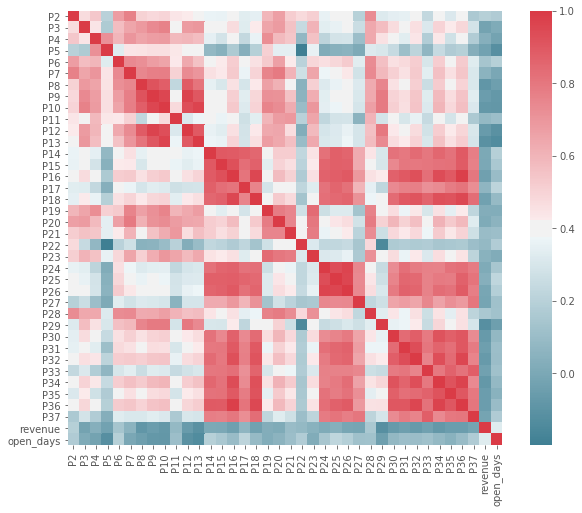

In [7]:
## View the correlation between all the numeric training data fields
f, ax = plt.subplots(figsize=(10, 8))
corr = train_df.iloc[:,5:].corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax);
# There are lots of strongly correlated fields,  
# likely within the Real Estate, Demographic, and Commerical groups.

In [8]:
# The 5 features with the highest correlation with revenue
corr['revenue'].sort_values(ascending=False)[1:6]

open_days    0.325821
P2           0.191518
P28          0.155534
P6           0.139094
P21          0.097411
Name: revenue, dtype: float64

In [9]:
# The 5 features with the lowest correlation with revenue
corr['revenue'].sort_values(ascending=True)[0:5]

P29   -0.114846
P13   -0.105085
P8    -0.084215
P10   -0.073220
P34   -0.072343
Name: revenue, dtype: float64

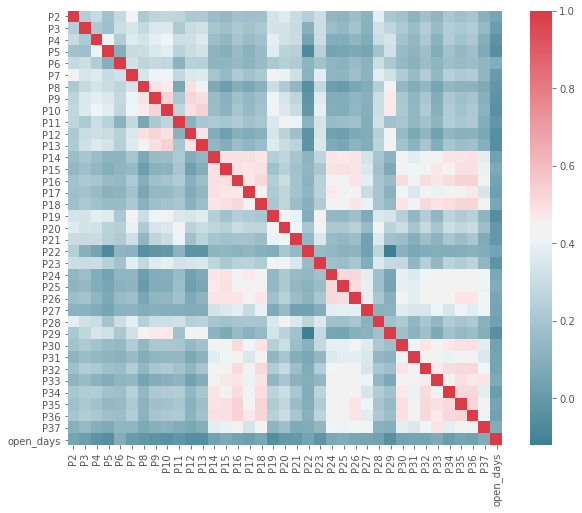

In [10]:
# There are much lower correlations between the test data fields.
# This could be because Kaggle likely made a bunch of fake test samples for the competition and the "real"
# test samples (a small subset of the given test rows) may have similar correlations as the training data fields.
f, ax = plt.subplots(figsize=(10, 8))
corr_test = test_df.iloc[:,5:].corr()
sns.heatmap(corr_test, mask=np.zeros_like(corr_test, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax);

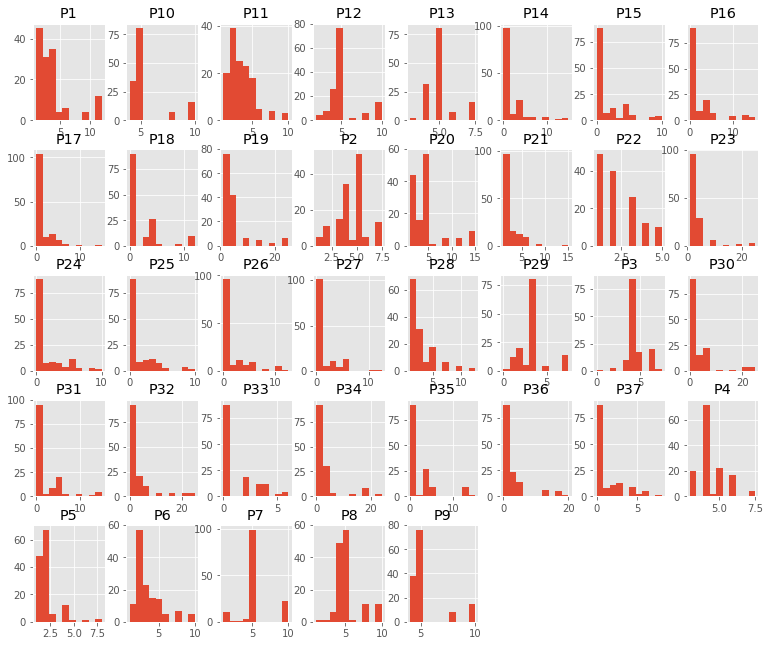

In [11]:
# View histograms of all the obfuscated features
p_features = [p for p in train_df.columns if p.startswith('P')]
train_df.hist(column=p_features, figsize=(13,11), layout=(5,8));

# Create Features and Regression Model

In [21]:
## Helper Functions
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error

# Make root mean squared error scorer to use in grid search 
def rmse(y_test, y_pred):
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    return rmse

rmse_scorer = make_scorer(rmse, greater_is_better=False)

# Function to view the explained variance of all the components of a
# principal components model and select the number of components at 
# chosen explained variance value (default 90%) 
def plot_explained_variance(eig_vals, exp_var_value=90):
    tot = sum(eig_vals)
    var_exp = [(i / tot)*100 for i in sorted(eig_vals, reverse=True)]
    cum_var_exp = np.cumsum(var_exp)
    num_comp = np.argwhere(cum_var_exp >=exp_var_value)[0][0]
    
    with plt.style.context('seaborn-whitegrid'):
        plt.figure(figsize=(6, 4))
        plt.bar(range(len(eig_vals)), var_exp, color='C0', align='center', label='individual explained variance')
        plt.step(range(len(eig_vals)), cum_var_exp, color='C1', where='mid', label='cumulative explained variance')
        plt.ylabel('Explained variance ratio')
        plt.xlabel('Principal components')
        plt.legend(loc='best')
        plt.title('{} Components explains > {}% variance'.format(num_comp, exp_var_value))
        plt.tight_layout()
    
    return num_comp

# Plot and compare the predictions from two models
def plot_predictions(y_true, y_pred1, y_pred2, 
                     model1_title='Model 1', model2_title='Model 2', 
                     weights = [0.5, 0.5]):
    rmse1 = rmse(y_true, y_pred1)
    mae1 = mean_absolute_error(y_true, y_pred1)
    rmse2 = rmse(y_true, y_pred2)
    mae2 = mean_absolute_error(y_true, y_pred2)
    weighted_pred = np.average([y_pred1, y_pred2], axis=0, weights=weights)
    rmseW = rmse(y_true, weighted_pred)
    maeW = mean_absolute_error(y_true, weighted_pred)
    max_value = max(y_true)
    
    f, axarr = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
    f.subplots_adjust(top=0.85, wspace = 0.3)
    f.suptitle('Weighted Model RMSE: {:,.0f}, MAE: {:,.0f}'.format(rmseW, maeW),
               y=1.0, fontsize=14, fontweight='semibold')

    axarr[0].plot(y_true, weighted_pred, 'o', markersize=6, color='0.3', label='Weighted Model')
    axarr[0].plot(y_true, y_pred1, 'o', markersize=5, color='C0', label=model1_title)
    axarr[0].plot([0, max_value], [0, max_value], 'k--')
    axarr[0].set_title('{}\nRMSE: {:,.0f}, MAE: {:,.0f}'.format(model1_title, rmse1, mae1))
    axarr[0].set_xlabel('Reported')
    axarr[0].set_ylabel('Predicted')
    axarr[0].legend()

    axarr[1].plot(y_true, weighted_pred, 'o', markersize=6, color='0.3', label='Weighted Model')
    axarr[1].plot(y_true, y_pred2, 'o', markersize=5, color='C1', label=model2_title)
    axarr[1].plot([0, max_value], [0, max_value], 'k--')
    axarr[1].set_title('{}\nRMSE: {:,.0f}, MAE: {:,.0f}'.format(model2_title, rmse2, mae2))
    axarr[1].set_xlabel('Reported')
    axarr[1].set_ylabel('Predicted')
    axarr[1].legend()

## Preprocess the data

In [13]:
## Create features
revenue = train_df.pop('revenue').values

# Use open_days plus all the obfuscated features with revenue correlation > abs(0.1) as numeric features
num_features = corr['revenue'].apply(lambda x: abs(x) > 0.1)
num_features = num_features[(num_features == True)].index.tolist()
num_features.remove('revenue')

# Use City Group and Type plus all the obfuscated features (besides those chosen above) as categorical features.
train_df.drop('Id', inplace=True, axis=1)
train_df.drop('City', inplace=True, axis=1)
cat_features = [f for f in train_df.columns if f not in num_features] 

train_num = train_df[num_features].values
test_num = test_df[num_features].values
train_cat = train_df[cat_features].values
test_cat = test_df[cat_features].values

## Preprocess the data ##
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from scipy.sparse import hstack

# Standardize numeric features by removing the mean and scaling to unit variance
scaler = preprocessing.StandardScaler().fit(train_num)
train_num_scaled = scaler.transform(train_num)
test_num_scaled = scaler.transform(test_num)
print 'Numeric features shape: training {}, test {}'.format(np.shape(train_num_scaled), np.shape(test_num_scaled))

# Give numeric labels to the categorical data
for n in range(0,train_cat.shape[1]):
    le = LabelEncoder()
    le.fit(np.concatenate((train_cat[:,n],test_cat[:,n]),axis=0))
    train_cat[:,n] = le.transform(train_cat[:,n])
    test_cat[:,n] = le.transform(test_cat[:,n])
print 'Categorical features shape: training {}, test {}'.format(np.shape(train_cat), np.shape(test_cat))

# Encode the labels 
enc = OneHotEncoder()
enc.fit(np.concatenate((train_cat,test_cat), axis=0))
train_enc = enc.transform(train_cat)
test_enc = enc.transform(test_cat)
print 'Encoded categorical features shape: training {}, test {}'.format(np.shape(train_enc), np.shape(test_enc))

# Concatenate the preprocessed numeric and encoded categorical features
Xtrain = hstack((train_num_scaled, train_enc)).toarray()
Xtest = hstack((test_num_scaled, test_enc)).toarray()
print 'Processed feature matrices shape: training {}, test {}'.format(np.shape(Xtrain), np.shape(Xtest))

Numeric features shape: training (137, 6), test (100000, 6)
Categorical features shape: training (137, 34), test (100000, 34)
Encoded categorical features shape: training (137, 277), test (100000, 277)
Processed feature matrices shape: training (137, 283), test (100000, 283)


## Reduce the Feature Dimensions

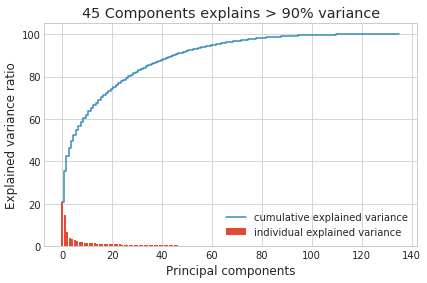

In [14]:
# Select the number of components that expain at least 90% of the variance
from sklearn.decomposition import KernelPCA
kpca = KernelPCA(kernel='rbf')
kpca.fit(Xtrain)
num_comp = plot_explained_variance(kpca.lambdas_, 90)

In [15]:
# Transform the features
kpca = KernelPCA(n_components=num_comp, kernel='rbf')
kpca.fit(Xtrain)
Xtrain_kpca = kpca.transform(Xtrain)
Xtest_kpca = kpca.transform(Xtest)
print 'Reduced feature matrices shapes: train {}, test {}'.format(np.shape(Xtrain_kpca), np.shape(Xtest_kpca))

Reduced feature matrices shapes: train (137, 45), test (100000, 45)


## Grid Search Model Parameters

In [17]:
# Grid Search Ridge Regression
from sklearn.grid_search import GridSearchCV
from sklearn import linear_model
from sklearn.cross_validation import ShuffleSplit

data = Xtrain_kpca
cv = ShuffleSplit(np.shape(data)[0], n_iter=5, test_size=0.25, random_state=2)
param_grid = [{'alpha': [1.0, 0.5, 0.3, 0.25, 0.2, 0.1, .05, 0.01]}]
lin = linear_model.Ridge()
clf = GridSearchCV(lin, param_grid, cv=cv, scoring=rmse_scorer, verbose=1)
clf.fit(data, revenue)
best_lin_params = clf.best_params_
print best_lin_params

Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 0.5}


[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    0.1s finished


In [18]:
# Grid Search SVR.
from sklearn.grid_search import GridSearchCV
from sklearn.svm import SVR
from sklearn.cross_validation import ShuffleSplit

data = Xtrain
cv = ShuffleSplit(np.shape(data)[0], n_iter=5, test_size=0.25, random_state=2)
param_grid = [{'C': [1e3, 1e4, 1e5, 1e6],
               'epsilon':[1e-2, 1e-1, 1e0, 1e1, 1e2], 
               'gamma':[1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2]}]
svr = SVR()
clf = GridSearchCV(svr, param_grid, cv=cv, scoring=rmse_scorer, verbose=1)
clf.fit(data, revenue)
best_svr_params = clf.best_params_
print best_svr_params

Fitting 5 folds for each of 120 candidates, totalling 600 fits
{'epsilon': 0.01, 'C': 1000000.0, 'gamma': 0.01}


[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    5.5s finished


## Cross-validate the Models and Save Predictions

In [19]:
## Cross-validation ##
from sklearn.cross_validation import train_test_split

svr_rmse_all = []
lin_rmse_all = []
weighted_rmse_all = []

data1 = Xtrain
test1 = Xtest
data2 = Xtrain_kpca
test2 = Xtest_kpca
weights = [0.5, 0.5]

random_states = [100, 10, 500, 700, 50, 5, 67, 222, 673, 490] # 10 iterations
for r in random_states:
    # Split the data into a training set and a test set
    X_train1, X_test1, y_train1, y_test1 = train_test_split(data1, revenue, test_size=0.25, random_state=r)
    X_train2, X_test2, y_train2, y_test2 = train_test_split(data2, revenue, test_size=0.25, random_state=r)

    # Initialize SVR model
    svr = SVR(gamma=best_svr_params['gamma'], 
              C=best_svr_params['C'], 
              epsilon=best_svr_params['epsilon'])
    # Fit the training data to the targets
    # Use the full features matrix
    svr.fit(X_train1, y_train1)
    # Make preditions
    preds1 = svr.predict(X_test1)

    # Initialize Ridge Regression model
    lin = linear_model.Ridge(alpha=best_lin_params['alpha'])
    # Fit the training data to the targets
    # Use the reduced feature matrix
    lin.fit(X_train2, y_train2)
    # Make preditions
    preds2 = lin.predict(X_test2)
    
    # Average the two model predictions
    weighted_pred = np.average([preds1, preds2], axis=0, weights=weights)
    
    # Calculate error metrics
    svr_metric = rmse(y_test1, preds1)
    svr_rmse_all.append(svr_metric)
    lin_metric = rmse(y_test2, preds2)
    lin_rmse_all.append(lin_metric)
    weighted_metric = rmse(y_test1, weighted_pred)
    weighted_rmse_all.append(weighted_metric)
    
print 'SVR cross-validated RMSE mean = {:,.0f}, std = {:,.0f}'.format(np.mean(svr_rmse_all),np.std(svr_rmse_all))
print 'Linear cross-validated RMSE mean = {:,.0f}, std = {:,.0f}'.format(np.mean(lin_rmse_all),np.std(lin_rmse_all))
print 'Weighted cross-validated RMSE mean = {:,.0f}, std = {:,.0f}'.format(np.mean(weighted_rmse_all),np.std(weighted_rmse_all))

## Fit the models to all the trainings samples and make preditions
svr.fit(data1, revenue)
svr_training_pred = svr.predict(data1)
preds1 = svr.predict(test1)
lin.fit(data2, revenue)
lin_training_pred = lin.predict(data2)
preds2 = lin.predict(test2)
weighted_pred = np.average([preds1, preds2], axis=0, weights=weights)

## Save predictions to csv file using sample submission format
sample_submission['Prediction'] = weighted_pred
sample_submission.to_csv('../../data/restaurant_revenue/submission.csv', index = False)

SVR cross-validated RMSE mean = 2,495,802, std = 810,191
Linear cross-validated RMSE mean = 2,430,116, std = 664,555
Weighted cross-validated RMSE mean = 2,425,673, std = 755,521


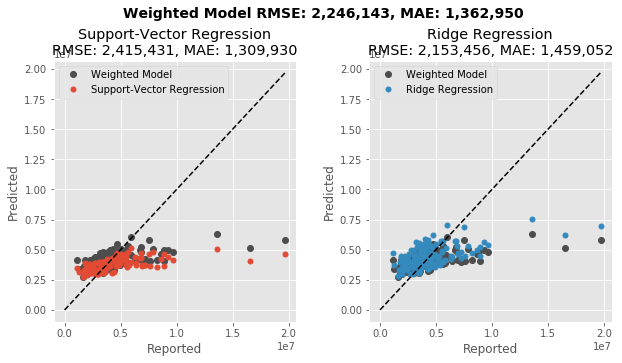

In [23]:
# Visualize the model predictions for the training data
# Both models are greatly underpredicting the large revenue restaurants.
# If you increase the gamma parameter for the SVR model,
# the RMSE goes down a lot for the training set, but you start to overfit the data and lower the CV score.
plot_predictions(revenue, svr_training_pred, lin_training_pred,
                 'Support-Vector Regression', 'Ridge Regression',
                 weights)